# Dinamika linijske konstrukcije z metodo končnih elementov
Marko Tacer, 23222087

In [1]:
import sympy as sym
import numpy as np
import scipy as sp
from scipy import linalg,spatial,signal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

V spodaj predstavljenem "notebooku" so uporabljene izpeljave za končni elementi palica in nosilec, ki smo jih prikazali na vajah. 

## Priprava linijskega modela

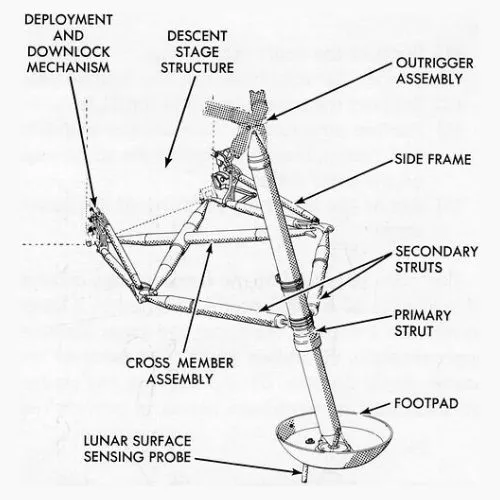

https://apollo11space.com/nasas-apollo-11-lunar-module-basic-facts/

## Osnovna (skupna) geometrija

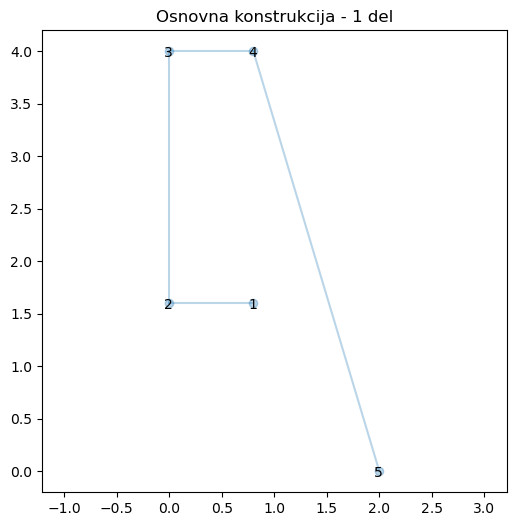

In [2]:
L1 = 2 # m - skupna dolžina
L2 = 4 # m - skupna višina
k1 = 0.4 # razmerje dolžine pritrjene konstrukcije
k2 = 0.4 # razmerje višine pritrjene konstrukcije

# Definicija skupnih vozlišč (5, ki jih že poznamo)
vozlisca_osn_sk = np.array([[k1 * L1, k2 * L2], [0, k2*L2], [0,L2], [k1 * L1, L2], [L1, 0]])

# Definicija elementov
elementi_osn_sk = np.array([[0, 1],[1, 2], [2, 3], [3, 4]]) #, [0, 5]])
# 
vozlisca_osn_sk = vozlisca_osn_sk.reshape(5, 2)

# Izris
fig, ax = plt.subplots(figsize = (6, 6))
ax.set_title('Osnovna konstrukcija - 1 del')
for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', color='C0', alpha=0.3)

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.3)
[plt.text(*c,n+1) for n,c in enumerate(vozlisca_osn_sk-0.05)];

ax.axis('equal')
fig.savefig('osnovna_konstrukcija_1.png')

Definicija funkcije zgoščanja. Sama funkcija omogoča, da posamezni element poljubno zgostimo. Še vedno pa lahko tudi definiramo število pod-elementov za vse elemente enako.

In [3]:
def zgostitev(vozlisca_osn, elementi_osn, number_of_elements = [2]):
    ''' 
    Definiramo osnovna vozlisca : vozlisca_osn
    Definiramo osnovne elemente : elementi_osn
    Definiramo array, ki doloca stevilo elementov na posameznem elementu : number_of_elements
        Če želimo povsod enako definiramo array z enim elementom
        Sicer pa array s številom elementov enakim številu elementov posameznega dela osnovne konstrukcije
    '''
    # Ko želimo povsod enako število elementov
    if len(number_of_elements) == 1:
        
        vozlisca = np.copy(vozlisca_osn)
        elementi = np.empty((0,2), int)
        
        for i in elementi_osn: 
            x = np.linspace(vozlisca[i[0],0], vozlisca_osn[i[1],0], number_of_elements[0] + 1)[1:-1]
            y = np.linspace(vozlisca[i[0],1], vozlisca_osn[i[1],1], number_of_elements[0] + 1)[1:-1]
            voz = np.column_stack((x, y))
            
            novi_ind_vozlisc = len(vozlisca) + np.arange(len(voz))
            vozlisca = np.append(vozlisca, voz, axis = 0)
            sez_voz = np.block([i[0],novi_ind_vozlisc,i[1]])
            elem = np.array([[sez_voz[_],sez_voz[_+1]] for _ in range(len(sez_voz)-1)])
            elementi = np.append(elementi, elem, axis = 0)
        return (vozlisca, elementi)
    
    # Če želimo različno število elementov (Pozor, dolžina number_of_elements mora biti enaka dolžini elementi_osn)
    elif len(number_of_elements) == len(elementi_osn):
        vozlisca = np.copy(vozlisca_osn)
        elementi = np.empty((0,2), int)
        
        for j in np.arange(len(elementi_osn)):
            x = np.linspace(vozlisca[elementi_osn[j][0],0], vozlisca_osn[elementi_osn[j][1],0], 1 + int(number_of_elements[j]))[1:-1]
            y = np.linspace(vozlisca[elementi_osn[j][0],1], vozlisca_osn[elementi_osn[j][1],1], 1 + int(number_of_elements[j]))[1:-1]
            voz = np.column_stack((x, y))
        
            novi_ind_vozlisc = len(vozlisca) + np.arange(len(voz))
            vozlisca = np.append(vozlisca, voz, axis = 0)
            sez_voz = np.block([elementi_osn[j][0], novi_ind_vozlisc, elementi_osn[j][1]])
            elem = np.array([[sez_voz[_],sez_voz[_+1]] for _ in range(len(sez_voz)-1)])
            elementi = np.append(elementi, elem, axis = 0)
        return (vozlisca, elementi)
    
    # Ko ne izberemo nobene od zgornjih opcij oz ne podamo pravilnega števila elementov
    else:
        print("Error!")
        print("Napačni vhodni podatki!")
        print("Ni zgostitve elementov!")
        vozlisca = np.copy(vozlisca_osn)
        elementi = np.empty((0,2), int)
        # Ni zgostitve
        number_of_elements = [1]
        
        for i in elementi_osn: 
            x = np.linspace(vozlisca[i[0],0], vozlisca_osn[i[1],0], number_of_elements[0] + 1)[1:-1]
            y = np.linspace(vozlisca[i[0],1], vozlisca_osn[i[1],1], number_of_elements[0] + 1)[1:-1]
            voz = np.column_stack((x, y))
            
            novi_ind_vozlisc = len(vozlisca) + np.arange(len(voz))
            vozlisca = np.append(vozlisca, voz, axis = 0)
            sez_voz = np.block([i[0],novi_ind_vozlisc,i[1]])
            elem = np.array([[sez_voz[_],sez_voz[_+1]] for _ in range(len(sez_voz)-1)])
            elementi = np.append(elementi, elem, axis = 0)
        return (vozlisca, elementi)

Še definicija transformacijske, masne in togostne matrike za okvir in paličje.

In [4]:
# OKVIR
# transformacijska matrika
def T(α):
    
    T = np.array([[ np.cos(α), np.sin(α), 0,         0,         0, 0],
                   [-np.sin(α), np.cos(α), 0,         0,         0, 0],
                   [         0,         0, 1,         0,         0, 0],
                   [         0,         0, 0, np.cos(α), np.sin(α), 0],
                   [         0,         0, 0,-np.sin(α), np.cos(α), 0],
                   [         0,         0, 0,         0,         0, 1]])
        
    return T

# masna matrika
def M_o(A, L, ρ, α):

    M_lok = ρ*A*L*np.array([[1/3,         0,         0, 1/6,         0,         0],
                            [  0,     13/35,  11*L/210,   0,      9/70, -13*L/420],
                            [  0,  11*L/210,  L**2/105,   0,  13*L/420, -L**2/140],
                            [1/6,         0,         0, 1/3,         0,         0],
                            [  0,      9/70,  13*L/420,   0,     13/35, -11*L/210],
                            [  0, -13*L/420, -L**2/140,   0, -11*L/210,  L**2/105]])
    
    return T(α).T @ M_lok @ T(α)

# togostna matrika
def K_o(A, E, I, L, α):

    K_lok = E/L*np.array([[ A,          0,      0, -A,          0,      0],
                          [ 0,  12*I/L**2,  6*I/L,  0, -12*I/L**2,  6*I/L],
                          [ 0,      6*I/L,    4*I,  0,     -6*I/L,    2*I],
                          [-A,          0,      0,  A,          0,      0],
                          [ 0, -12*I/L**2, -6*I/L,  0,  12*I/L**2, -6*I/L],
                          [ 0,      6*I/L,    2*I,  0,     -6*I/L,    4*I]])
    
    return T(α).T @ K_lok @ T(α)

In [5]:
# PALIČJE

# masna matrika
def M_p(A, L, ρ):

    M = ρ*A*L/6*np.array([
    [2, 0, 1, 0],
    [0, 2, 0, 1],
    [1, 0, 2, 0],
    [0, 1, 0, 2]])
    
    return M

def K_p(A, E, L, α):

    c = np.cos(α)
    s = np.sin(α)
    
    K = A*E/L*np.array([
    [ c**2,   s*c, -c**2,  -s*c],
    [  s*c,  s**2,  -s*c, -s**2],
    [-c**2,  -s*c,  c**2,   s*c],
    [ -c*s, -s**2,   s*c,  s**2]])
    
    return K

## Struktura 1

Našo strukturo 1 predstavljajo prva 4 vozlišča skupne strukture. Prav tako si elementi strukture A prvi trije iz skupne konstrukcije.

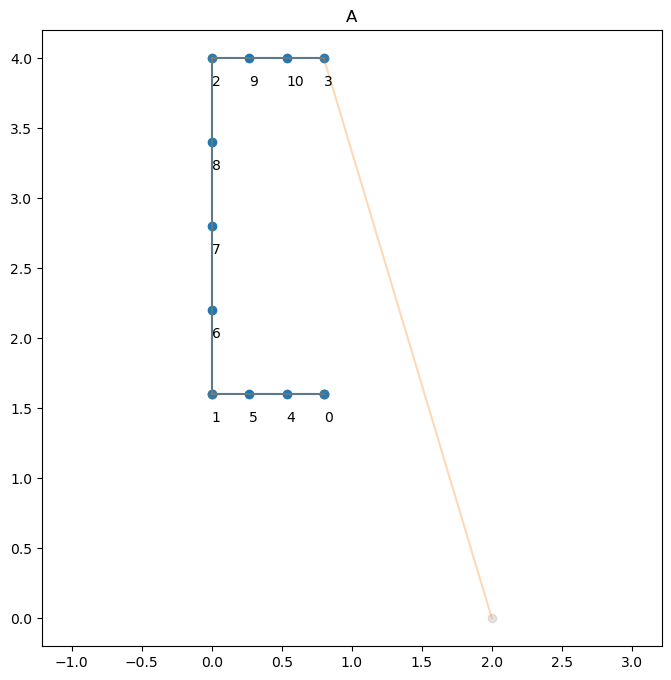

In [6]:
vozlisca_osn_A = vozlisca_osn_sk[:4]
elementi_osn_A = elementi_osn_sk[:3]

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("A")
for i in vozlisca_osn_A[:-2]:
    ax.plot(i[0], i[1], 'o')

for element in elementi_osn_A:
    x = [vozlisca_osn_A[element[0], 0], vozlisca_osn_A[element[1], 0]]
    y = [vozlisca_osn_A[element[0], 1], vozlisca_osn_A[element[1], 1]]
    ax.plot(x, y, 'C0')


ax.axis('equal')

vozlisca_A, elementi_A = zgostitev(vozlisca_osn_A, elementi_osn_A, [3, 4, 3])

for i in np.arange(len(vozlisca_A)):
    ax.plot(vozlisca_A[i][0], vozlisca_A[i][1], 'o', color='C0')
[ax.text(*c,n) for n,c in enumerate(vozlisca_A-[0, 0.2])];

# Izris backup strukture
for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', alpha=0.2, color="gray")

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C1', alpha=0.3)
fig.savefig('osnovna_konstrukcija_2.png')

In [7]:
# Podstruktura A - okvir

# Definiramo okrolo cev, iz 7178-T6 aluminija
h = 0.005 # m - debelina stene
D = 0.2 # m - zunanji premer
d = D-2*h # m - notranji premer

ρ_A = 2.82*1000 # kg /m3
E_A = 80e9 # Aluminij 7178-T6

# Votli okrogli profil
A_A = np.pi * ((D/2)**2 - (d/2)**2)
I_A = 14567871.94* 10**(-12) #np.pi/4 * (D**4 - d**4)

# zlaganje
n_ps_A = 3*len(vozlisca_A)
M_glob_A = np.zeros((n_ps_A,n_ps_A))
K_glob_A = np.zeros((n_ps_A,n_ps_A))

for element in elementi_A:
    Le = sp.spatial.distance.euclidean(vozlisca_A[element[0]], vozlisca_A[element[1]])
    αe = np.arctan2(np.diff(vozlisca_A[element,1]) , np.diff(vozlisca_A[element,0]))[0]
    ind = (3*element[:,None] + np.array([0, 1, 2])).flatten()
    
    M_glob_A[ind[:,None],ind] += M_o(A_A, Le, ρ_A, αe)
    K_glob_A[ind[:,None],ind] += K_o(A_A, E_A, I_A, Le, αe)


print(f'Število osnovnih vozlisc: \t {len(vozlisca_osn_A)}')
print(f'Število osnovnih elementov: \t {len(elementi_osn_A)}')
print(f'Število zgoscenih vozlisc: \t {len(vozlisca_A)}')
print(f'Število zgoscenih elementov: \t {len(elementi_A)}')
print()
print(f'Oblika vozlisca_A : {vozlisca_A.shape}, oblika elementi_A: {elementi_A.shape}')
print(f'Oblika vozlisca_osn_A : {vozlisca_osn_A.shape}, oblika elementi_osn_A: {elementi_osn_A.shape}')
print()
print(f'M_glob_A : {M_glob_A.shape}, \t K_glob_A: {K_glob_A.shape}')
print(f'h[mm] \t\t D[cm] \t\t d[cm] \t\t A[cm2] \t I[cm4] \t ρ[kg/m3] \t E[GPa]')
print(f'{h*1000:.2f} \t\t {D*100:.2f} \t\t {d*100:.2f} \t\t {A_A*10000:.2f} \t\t {I_A*100**4:.2f} \t\t {ρ_A:.2f} \t {E_A/10**9:.2f}')

Število osnovnih vozlisc: 	 4
Število osnovnih elementov: 	 3
Število zgoscenih vozlisc: 	 11
Število zgoscenih elementov: 	 10

Oblika vozlisca_A : (11, 2), oblika elementi_A: (10, 2)
Oblika vozlisca_osn_A : (4, 2), oblika elementi_osn_A: (3, 2)

M_glob_A : (33, 33), 	 K_glob_A: (33, 33)
h[mm] 		 D[cm] 		 d[cm] 		 A[cm2] 	 I[cm4] 	 ρ[kg/m3] 	 E[GPa]
5.00 		 20.00 		 19.00 		 30.63 		 1456.79 		 2820.00 	 80.00


## Struktura 2 (C)

Struktura C je v našem primeru zgolj en nosilec, ki je členkasto pritrjen na strukturo A. To je pravzaprav noga, s katero plovilo "stopi" na površino

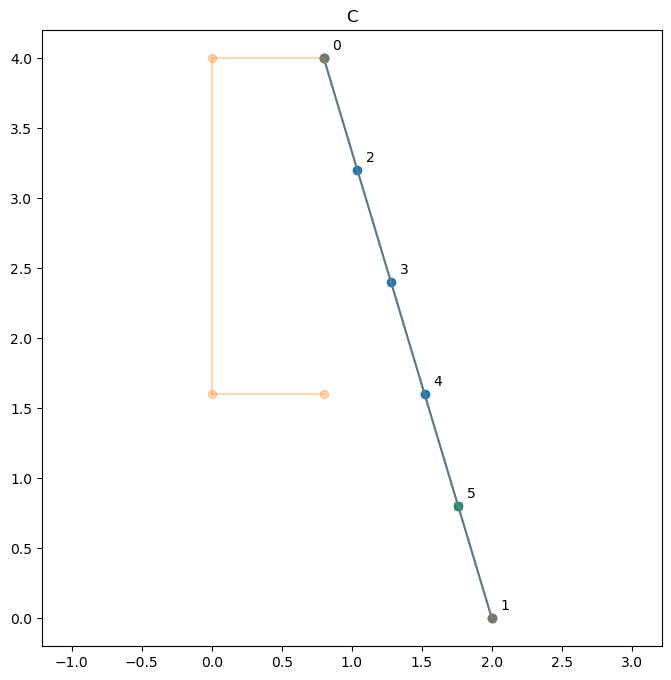

In [13]:
vozlisca_osn_C = vozlisca_osn_sk[-2:]
elementi_osn_C = np.array([[0,1]])
vozlisca_osn_C = vozlisca_osn_C.reshape(2, 2)

fig, ax = plt.subplots(figsize = (8, 8))
ax.set_title("C")

for i in vozlisca_osn_C:
    ax.plot(i[0], i[1], 'o')

for element in elementi_osn_C:
    x = [vozlisca_osn_C[element[0], 0], vozlisca_osn_C[element[1], 0]]
    y = [vozlisca_osn_C[element[0], 1], vozlisca_osn_C[element[1], 1]]
    ax.plot(x, y, 'C0')

ax.axis('equal')

vozlisca_C, elementi_C = zgostitev(vozlisca_osn_C[:], elementi_osn_C, [5])


for i in np.arange(len(vozlisca_C)):
    ax.plot(vozlisca_C[i][0], vozlisca_C[i][1], 'o', color='C0')
[ax.text(*c, n) for n,c in enumerate(vozlisca_C  + 0.06)];
ax.plot(vozlisca_C[5][0], vozlisca_C[5][1], 'x')

for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', alpha=0.3, color="C1")

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C1', alpha=0.3)
fig.savefig('osnovna_konstrukcija_3.png')

In [14]:
# Podstruktura C - okvir

h = 0.008 # m
D = 0.3 # m
d = D-2*h

ρ_C = ρ_A # kg /m3
E_C = 80e9 # Pa recimo nek specialen Al

A_C = np.pi * ((D/2)**2 - (d/2)**2)
I_C = 78270873.76 * 10**(-12)  #np.pi/4 * (D**4 - d**4)

# zlaganje
n_ps_C = 3*len(vozlisca_C)
M_glob_C = np.zeros((n_ps_C,n_ps_C))
K_glob_C = np.zeros((n_ps_C,n_ps_C))

for element in elementi_C:
    Le = sp.spatial.distance.euclidean(vozlisca_C[element[0]], vozlisca_C[element[1]])
    αe = np.arctan2(np.diff(vozlisca_C[element,1]) , np.diff(vozlisca_C[element,0]))[0]
    ind = (3*element[:,None] + np.array([0, 1, 2])).flatten()
    
    M_glob_C[ind[:,None],ind] += M_o(A_C, Le, ρ_C, αe)
    K_glob_C[ind[:,None],ind] += K_o(A_C, E_C, I_C, Le, αe)
    


print(f'Stevilo osnovnih vozlisc: \t {len(vozlisca_osn_C)}')
print(f'Stevilo osnovnih elementov: \t {len(elementi_osn_C)}')
print(f'Stevilo zgoscenih vozlisc: \t {len(vozlisca_C)}')
print(f'Stevilo zgoscenih elementov: \t {len(elementi_C)}')
print()
print(f'Oblika vozlisca_C : {vozlisca_C.shape}, oblika elementi_C: {elementi_C.shape}')
print(f'Oblika vozlisca_osn_C : {vozlisca_osn_C.shape}, oblika elementi_osn_C: {elementi_osn_C.shape}')
print()
print(f'M_glob_C : {M_glob_C.shape}, \t K_glob_C: {K_glob_C.shape}')
print(f'h[mm] \t\t D[cm] \t\t d[cm] \t\t A[cm2] \t I[cm4] \t ρ[kg/m3] \t E[GPa]')
print(f'{h*1000:.2f} \t\t {D*100:.2f} \t\t {d*100:.2f} \t\t {A_C*10000:.2f} \t\t {I_C*100**4:.2f} \t\t {ρ_C:.2f} \t {E_C/10**9:.2f}')

Stevilo osnovnih vozlisc: 	 2
Stevilo osnovnih elementov: 	 1
Stevilo zgoscenih vozlisc: 	 6
Stevilo zgoscenih elementov: 	 5

Oblika vozlisca_C : (6, 2), oblika elementi_C: (5, 2)
Oblika vozlisca_osn_C : (2, 2), oblika elementi_osn_C: (1, 2)

M_glob_C : (18, 18), 	 K_glob_C: (18, 18)
h[mm] 		 D[cm] 		 d[cm] 		 A[cm2] 	 I[cm4] 	 ρ[kg/m3] 	 E[GPa]
8.00 		 30.00 		 28.40 		 73.39 		 7827.09 		 2820.00 	 80.00


## Struktura 3 (B)

Pri strukturi B pa definiramo palico. Za povezuje prvo voylišče strukture A in izbrano vozližče na nosilcu C. 

In [16]:
# Na katero vozlišče strukture C se pripenja naša palica (B)
indeks_C = vozlisca_C.shape[0]//3 + vozlisca_C.shape[0]//6 - 0;
print(f'Koordinati pripenjališča')
print()
print(f'Vozlišče \t x\t y')
print(f'{indeks_C} \t\t{vozlisca_C[indeks_C][0]:.2f}\t{vozlisca_C[indeks_C][1]:.2f} ')

vozlisca_osn_B = np.hstack((vozlisca_osn_sk[0], vozlisca_C[indeks_C])).reshape(2, 2)
elementi_osn_B = np.array([[0,1]])

vozlisca_B, elementi_B = zgostitev(vozlisca_osn_B[:], elementi_osn_B, [1]) # 1, saj zgostitve pri palici ni smiselno delati

Koordinati pripenjališča

Vozlišče 	 x	 y
3 		1.28	2.40 


In [17]:
vozlisca_B[1, :]

array([1.28, 2.4 ])

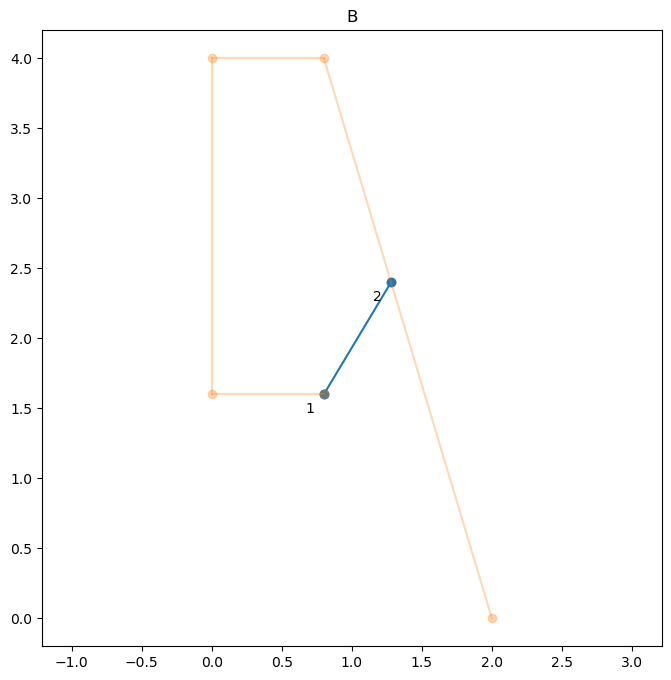

In [18]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.set_title("B")
for i in vozlisca_osn_B:
    ax.plot(i[0], i[1], 'o')

for element in elementi_osn_B:
    x = [vozlisca_osn_B[element[0], 0], vozlisca_osn_B[element[1], 0]]
    y = [vozlisca_osn_B[element[0], 1], vozlisca_osn_B[element[1], 1]]
    ax.plot(x, y, 'C0')

ax.axis('equal')
for i in np.arange(len(vozlisca_B)):
    ax.plot(vozlisca_B[i][0], vozlisca_B[i][1], 'o', color='C0')
[ax.text(*c, n+1) for n,c in enumerate(vozlisca_B  - 0.13)];

# Izris backup strukture
for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', alpha=0.3, color="C1")

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C1', alpha=0.3)
fig.savefig('osnovna_konstrukcija_4.png')


In [19]:
# Podstruktura B - paličje

# recimo, da je palica iz enakeag materiala, le da je profil poln
d = 0.10 # m

ρ_B = ρ_A # kg /m3
E_B = E_A # Pa
A_B = np.pi * d**2 / 4 # m^2

# zlaganje
n_ps_B = 2*len(vozlisca_B)
M_glob_B = np.zeros((n_ps_B,n_ps_B))
K_glob_B = np.zeros((n_ps_B,n_ps_B))

for element in elementi_B:
    Le = sp.spatial.distance.euclidean(vozlisca_B[element[0]], vozlisca_B[element[1]])
    αe = np.arctan2(np.diff(vozlisca_B[element,1]) , np.diff(vozlisca_B[element,0]))[0]
    ind = (2*element[:,None] + np.array([0, 1])).flatten()
    
    M_glob_B[ind[:,None],ind] += M_p(A_B, Le, ρ_B)
    K_glob_B[ind[:,None],ind] += K_p(A_B, E_B, Le, αe)


print(f'Število osnovnih vozlišč: \t {len(vozlisca_osn_B)}')
print(f'Število osnovnih elementov: \t {len(elementi_osn_B)}')
print(f'Število zgoščenih vozlišč: \t {len(vozlisca_B)}')
print(f'Število zgoščenih elementov: \t {len(elementi_B)}')
print()
print(f'Oblika vozlisca_B : {vozlisca_B.shape}, oblika elementi_B: {elementi_B.shape}')
print(f'Oblika vozlisca_osn_B : {vozlisca_osn_B.shape}, oblika elementi_osn_B: {elementi_osn_B.shape}')
print()
print(f'M_glob_B : {M_glob_B.shape}, \t K_glob_B: {K_glob_B.shape}')
print(f'd[cm] \t ρ[kg/m3] \t E[GPa] \t A[cm2]')
print(f'{d*100:.2f} \t {ρ_B:.2f} \t {E_B/10**9:.2f} \t\t {A_B*10000:.2f}')

Število osnovnih vozlišč: 	 2
Število osnovnih elementov: 	 1
Število zgoščenih vozlišč: 	 2
Število zgoščenih elementov: 	 1

Oblika vozlisca_B : (2, 2), oblika elementi_B: (1, 2)
Oblika vozlisca_osn_B : (2, 2), oblika elementi_osn_B: (1, 2)

M_glob_B : (4, 4), 	 K_glob_B: (4, 4)
d[cm] 	 ρ[kg/m3] 	 E[GPa] 	 A[cm2]
10.00 	 2820.00 	 80.00 		 78.54


## Skupna geometrija

Dodamo vozlisce, ki smo si ga izbrali pri strukturi B

In [20]:
vozlisca_osn_sk = np.vstack((vozlisca_osn_sk, vozlisca_B[-1, :]))
elementi_osn_sk = np.vstack((elementi_osn_sk, [0, -1]))


Skupna (osnovna) vozlišča: 6
Skupni (osnovni) elementi: 5


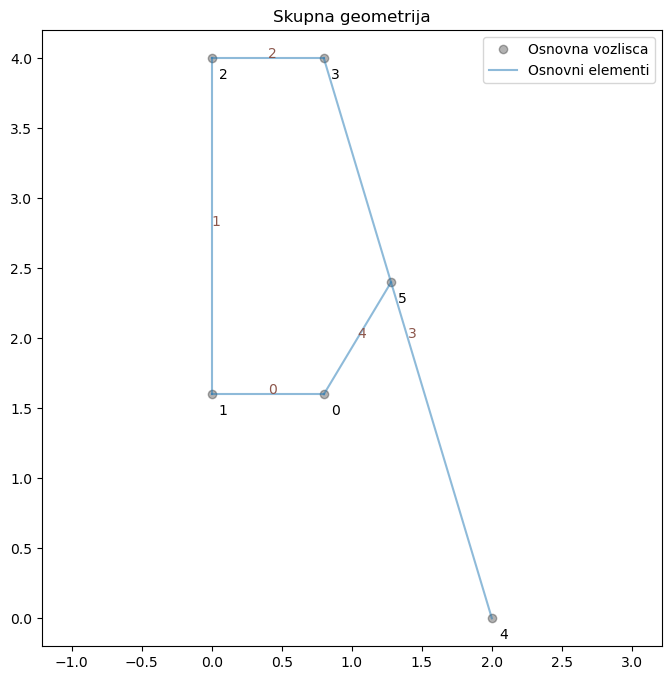

In [21]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.set_title("Skupna geometrija")

for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', color='black', alpha=0.3, label='Osnovna vozlisca' if i[0] == 2 else "")

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5, label='Osnovni elementi' if element[1] == -1 else "")
[ax.text(*c,n) for n, c in enumerate(vozlisca_osn_sk-[-0.05, 0.15])];

location_el = np.empty((0,2))
for i in range(len(elementi_osn_sk)):
    location_el=np.append(location_el, np.array([[np.sum(vozlisca_osn_sk[elementi_osn_sk[i],0])/2, np.sum(vozlisca_osn_sk[elementi_osn_sk[i], 1])/2]]),axis=0)

[ax.annotate(g, (location_el[g, 0], location_el[g, 1]), color='C5', size=10) for g in range(len(elementi_osn_sk))];
ax.axis('equal')
ax.legend()
fig.savefig('osnovna_konstrukcija_5.png')

print(f'Skupna (osnovna) vozlišča: {vozlisca_osn_sk.shape[0]}')
print(f'Skupni (osnovni) elementi: {elementi_osn_sk.shape[0]}')

## Diskretiziran sistem

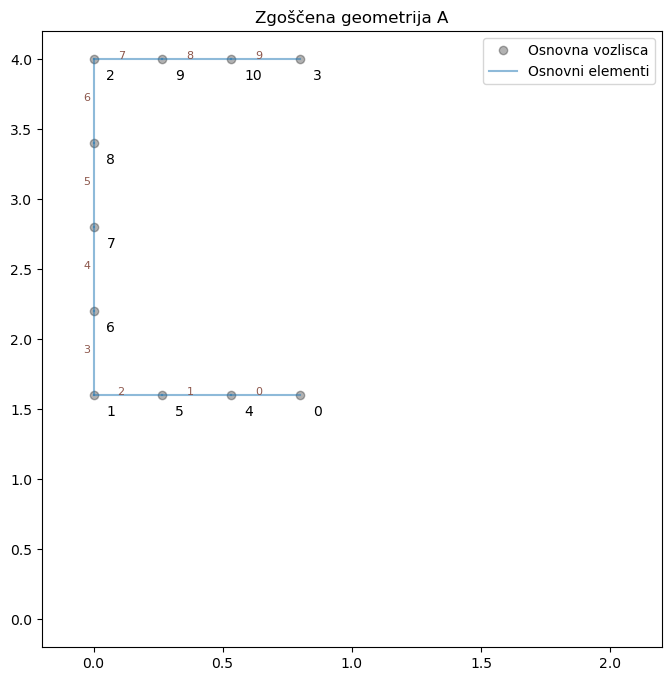

In [22]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title("Zgoščena geometrija A")

for i in vozlisca_A:
    ax.plot(i[0], i[1], 'o', color='black', alpha=0.3, label='Osnovna vozlisca' if i[0]+i[1] == 4.8 else "")

for element in elementi_A:
    x = [vozlisca_A[element[0], 0], vozlisca_A[element[1], 0]]
    y = [vozlisca_A[element[0], 1], vozlisca_A[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5, label='Osnovni elementi' if element[0] == 0 else "")
[ax.text(*c,n) for n, c in enumerate(vozlisca_A-[-0.05, 0.15])];

location_el = np.empty((0,2))
for i in range(len(elementi_A)):
    location_el=np.append(location_el, np.array([[np.sum(vozlisca_A[elementi_A[i],0])/2, np.sum(vozlisca_A[elementi_A[i], 1])/2]]),axis=0)

[ax.annotate(g, (location_el[g, 0]-0.04, location_el[g, 1]), color='C5', size=8) for g in range(len(elementi_A))];
ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)
ax.legend()
fig.savefig('osnovna_konstrukcija_A.png')

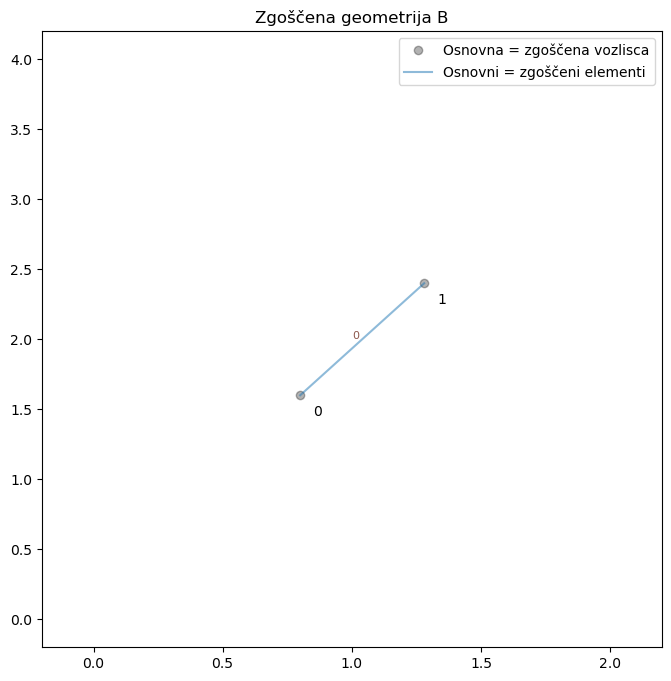

In [23]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title("Zgoščena geometrija B")

for i in vozlisca_B:
    ax.plot(i[0], i[1], 'o', color='black', alpha=0.3, label='Osnovna = zgoščena vozlisca' if i[0] == 0.8 else "")

for element in elementi_B:
    x = [vozlisca_B[element[0], 0], vozlisca_B[element[1], 0]]
    y = [vozlisca_B[element[0], 1], vozlisca_B[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5, label='Osnovni = zgoščeni elementi' if element[1] == 1 else "")
[ax.text(*c,n) for n, c in enumerate(vozlisca_B-[-0.05, 0.15])];

location_el = np.empty((0,2))
for i in range(len(elementi_B)):
    location_el=np.append(location_el, np.array([[np.sum(vozlisca_B[elementi_B[i],0])/2, np.sum(vozlisca_B[elementi_B[i], 1])/2]]),axis=0)

[ax.annotate(g, (location_el[g, 0]-0.04, location_el[g, 1]), color='C5', size=8) for g in range(len(elementi_B))];
ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)
ax.legend()
fig.savefig('osnovna_konstrukcija_B.png')

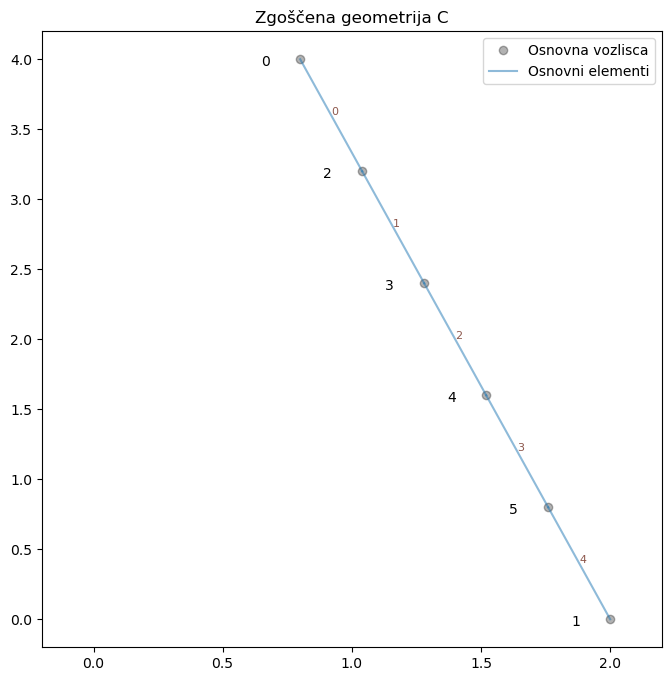

In [24]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.set_title("Zgoščena geometrija C")

for i in vozlisca_C:
    ax.plot(i[0], i[1], 'o', color='black', alpha=0.3, label='Osnovna vozlisca' if i[0] == 2 else "")

for element in elementi_C:
    x = [vozlisca_C[element[0], 0], vozlisca_C[element[1], 0]]
    y = [vozlisca_C[element[0], 1], vozlisca_C[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5, label='Osnovni elementi' if element[1] == 1 else "")
[ax.text(*c,n) for n, c in enumerate(vozlisca_C+[-0.15, -0.05])];

location_el = np.empty((0,2))
for i in range(len(elementi_C)):
    location_el=np.append(location_el, np.array([[np.sum(vozlisca_C[elementi_C[i],0])/2, np.sum(vozlisca_C[elementi_C[i], 1])/2]]),axis=0)

[ax.annotate(g, (location_el[g, 0], location_el[g, 1]), color='C5', size=8) for g in range(len(elementi_C))];
ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)
ax.legend()
fig.savefig('osnovna_konstrukcija_C.png')

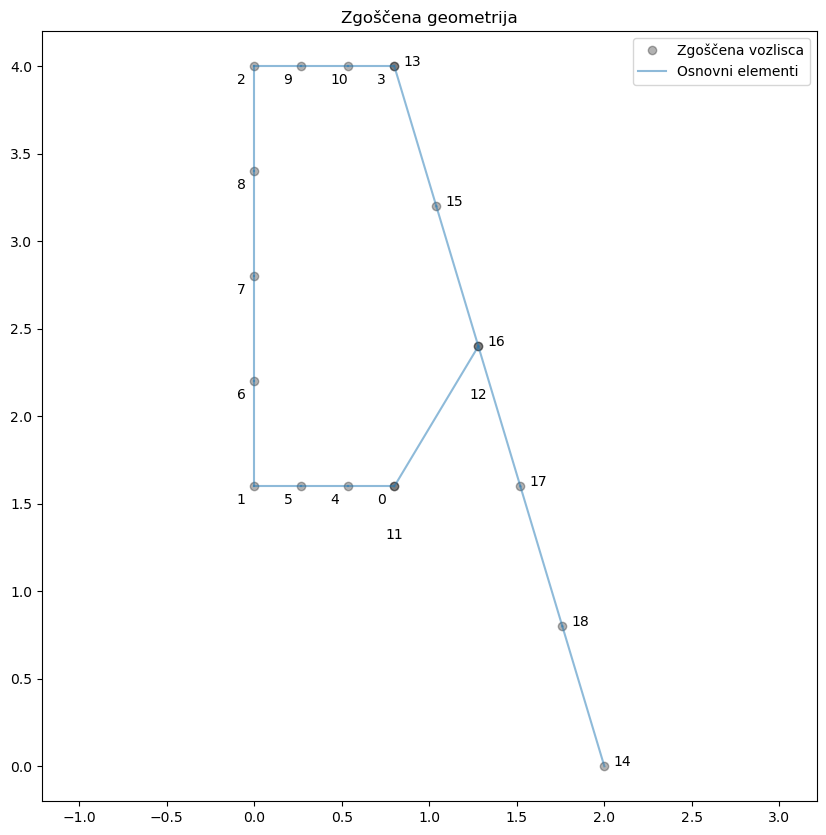

In [25]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_title("Zgoščena geometrija")

v = np.vstack((vozlisca_A, vozlisca_B, vozlisca_C))
e  = np.vstack((elementi_A, elementi_B, elementi_C))
for i in v:
    ax.plot(i[0], i[1], 'o', color='black', alpha=0.3, label='Zgoščena vozlisca' if i[0] == 2 else "")

for element in elementi_A:
    x = [vozlisca_A[element[0], 0], vozlisca_A[element[1], 0]]
    y = [vozlisca_A[element[0], 1], vozlisca_A[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5)#, label='Osnovni elementi' if element[1] == 1 else "")

for element in elementi_B:
    x = [vozlisca_B[element[0], 0], vozlisca_B[element[1], 0]]
    y = [vozlisca_B[element[0], 1], vozlisca_B[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5)#, label='Osnovni elementi' if element[1] == 1 else "")

for element in elementi_C:
    x = [vozlisca_C[element[0], 0], vozlisca_C[element[1], 0]]
    y = [vozlisca_C[element[0], 1], vozlisca_C[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5, label='Osnovni elementi' if element[1] == 1 else "")

[ax.text(*c,n) for n, c in enumerate(v[:len(vozlisca_A), :]-[0.1, 0.1])];
[ax.text(*c,n+len(vozlisca_A)) for n, c in enumerate(v[len(vozlisca_A):len(vozlisca_A)+len(vozlisca_B), :]-[0.05, 0.3])];
[ax.text(*c,n+len(vozlisca_A)+len(vozlisca_B)) for n, c in enumerate(v[-len(vozlisca_C):, :] + [0.05, 0])];

ax.axis('equal')

ax.legend();
fig.savefig('osnovna_konstrukcija_SK.png')

## Robni pogoji

V naslednjem poglavju definiramo robne pogoje in pogoje konsistentnega prehoda. Ker imam tri strukture in robne pogoje samo pri dveh je potrebno samo skupno matriko C malo prilagoditi.

In [26]:
# A - robni pogoji
ind_vpetih_ps_A = np.array([3, 4, 6, 7]) # definiramo dva vozlišča, ki sta vpeta tako, da so onemogočeni pomiki, rotacija pa ne - členkasto
# Naredimo prazno matriko in dodamo 1 na mesta, kjer so vpete PS
C_A_rp = np.zeros((len(ind_vpetih_ps_A),n_ps_A)) 
C_A_rp[np.arange(len(ind_vpetih_ps_A)),ind_vpetih_ps_A] = 1

# C - robni pogoji
# Ponovimo vajo za strukturo C
ind_vpetih_ps_C = np.array([3, 4])
C_C_rp = np.zeros((len(ind_vpetih_ps_C),n_ps_C))
C_C_rp[np.arange(len(ind_vpetih_ps_C)),ind_vpetih_ps_C] = 1

# Zložimo skupaj A in C
# Ju diagonalno zložimo skupaj
C_rp_AC = sp.linalg.block_diag(C_A_rp, C_C_rp)

# Dodamo še prazne "stolpce" zaradi B-ja, ki nima "robnih pogojev"
C_rp_B = np.zeros((C_rp_AC.shape[0], n_ps_B))

# Sestavimo te tri (dva) skupaj
C_rp_ABC = np.c_[C_rp_AC[:, :n_ps_A], C_rp_B, C_rp_AC[:, -n_ps_C:]]
C_rp_ABC.shape

# A B C povezava

# A
C_A_pov = np.zeros((7,n_ps_A))
C_B_pov = np.zeros((7,n_ps_B))
C_C_pov = np.zeros((7,n_ps_C))

# Povezava A-C
C_A_pov[[0,1],[9, 10]] = 1                          # vozlisce indeks 3 x,y  (A)
C_C_pov[[0,1],[0,1]] = -1                           # vozlisce indeks 0 x,y  (C)

# A-B
# x
C_A_pov[[4, 5],[0, 1]] = -1                               # vozlisce indeks 3 x,y  (A)
C_B_pov[[4, 5],[0, 1]] = 1
# y
# C_A_pov[[5],[1]] = -1                         # vozlisce indeks 3 x,y  (A)
# C_B_pov[[5],[1]] = 1

# B-C
C_B_pov[[6,3],[2,3]] = 1                           # vozlisce indeks 1 x,y        (B)
C_C_pov[[6,3],[3*indeks_C, 3*indeks_C + 1]] = -1    # vozlisce indeks "indeks_C" x,y (C)


C_ABC_pov = np.hstack([C_A_pov, C_B_pov, C_C_pov])
C_ABC_pov = C_ABC_pov[[0,1,4,5,6,3],:]

# združeno
C = np.vstack([C_rp_ABC, C_ABC_pov])
L_ABC = sp.linalg.null_space(C)

# združitev masne in togostne matrike
M_glob_ABC = L_ABC.T @ sp.linalg.block_diag(M_glob_A, M_glob_B, M_glob_C) @ L_ABC
K_glob_ABC = L_ABC.T @ sp.linalg.block_diag(K_glob_A, K_glob_B, K_glob_C) @ L_ABC

print(f'DoF A : \t\t{n_ps_A}')
print(f'DoF B : \t\t{n_ps_B}')
print(f'DoF C : \t\t{n_ps_C}')
print(f'Skupaj : \t\t{n_ps_A + n_ps_B + n_ps_C}')
print(f'L_ABC : \t\t{L_ABC.shape[0]}')
print(f'C_rp_ABC shape: \t{C_rp_ABC.shape}')
print(f'C_ABC_pov shape: \t{C_ABC_pov.shape}')
print(f'C shape: \t\t{C.shape}')
print()

DoF A : 		33
DoF B : 		4
DoF C : 		18
Skupaj : 		55
L_ABC : 		55
C_rp_ABC shape: 	(6, 55)
C_ABC_pov shape: 	(6, 55)
C shape: 		(12, 55)



## Modalna analiza

Izvedemo mdoalno analizo, za ka potrebujemo skupno masno matriko in skupno togostno matriko: Zgoraj smo jih definirali kot M_glob_ABC in K_glob_ABC

In [27]:
# problem lastnih vrednosti
eig_val, eig_vec = sp.linalg.eig(K_glob_ABC, M_glob_ABC)

# urejanje po velikosti
_ind = np.argsort(np.abs(eig_val))
eig_val = np.abs(eig_val[_ind])
eig_vec = eig_vec[:,_ind]

eig_freq = np.abs(eig_val)**0.5 / 2 / np.pi

# interpretacija rezultata
L_A = L_ABC[:n_ps_A, :]
L_B = L_ABC[n_ps_A:n_ps_A + n_ps_B, :]
L_C = L_ABC[-n_ps_C:, :]

eig_vec_A = L_A @ eig_vec
eig_vec_B = L_B @ eig_vec
eig_vec_C = L_C @ eig_vec

print(f'N \t [Hz]')
print("-----------------")
for i in np.arange(18):
    print(f'{i} \t {eig_freq[i].round(1)}')
    
    

N 	 [Hz]
-----------------
0 	 49.1
1 	 170.6
2 	 187.9
3 	 284.1
4 	 410.5
5 	 494.0
6 	 673.1
7 	 764.2
8 	 906.9
9 	 969.2
10 	 1058.9
11 	 1138.3
12 	 1171.2
13 	 1311.4
14 	 1449.4
15 	 1536.7
16 	 1943.2
17 	 2106.1


In [28]:
# eig_vec.shape

### Prikaz lastnih oblik - statično

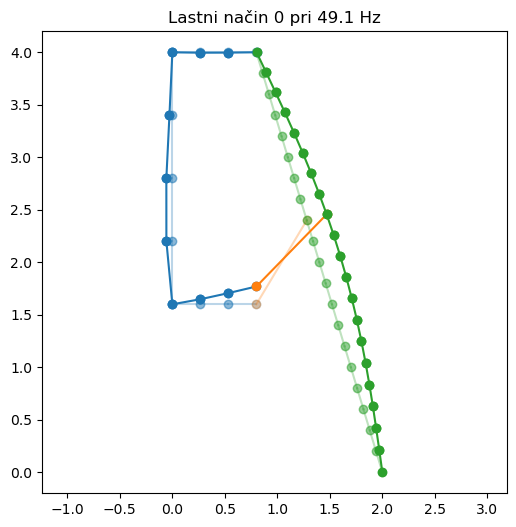

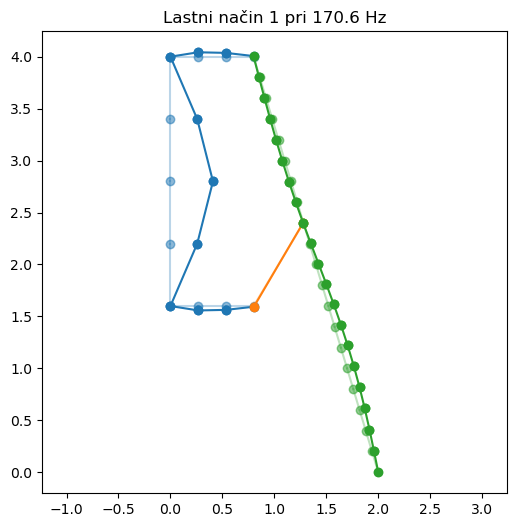

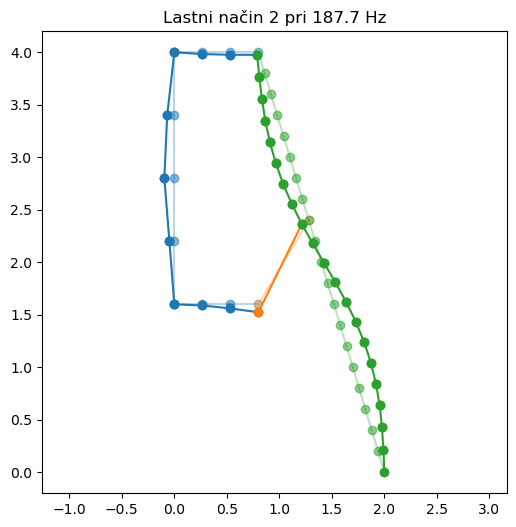

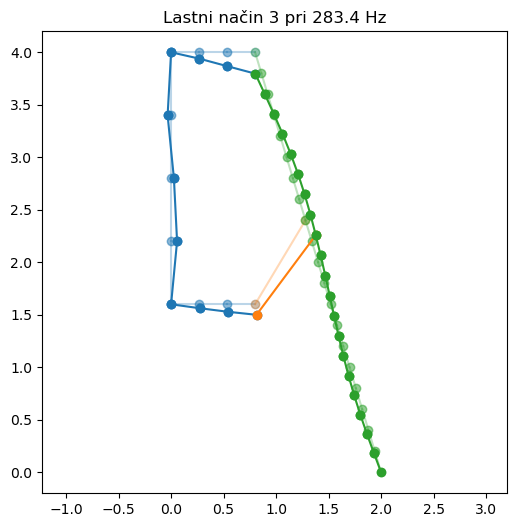

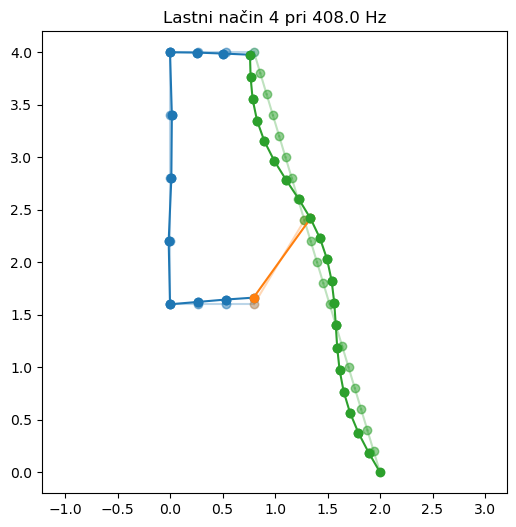

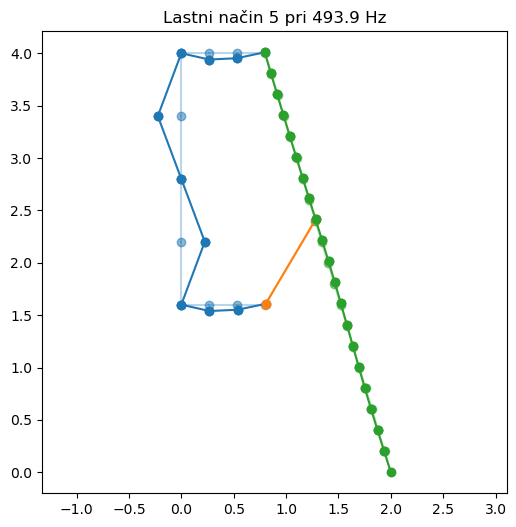

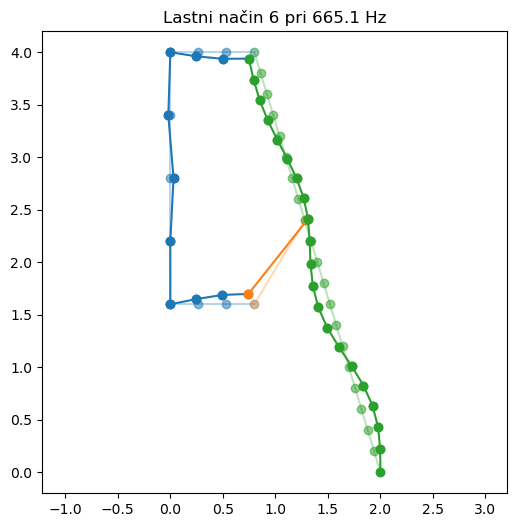

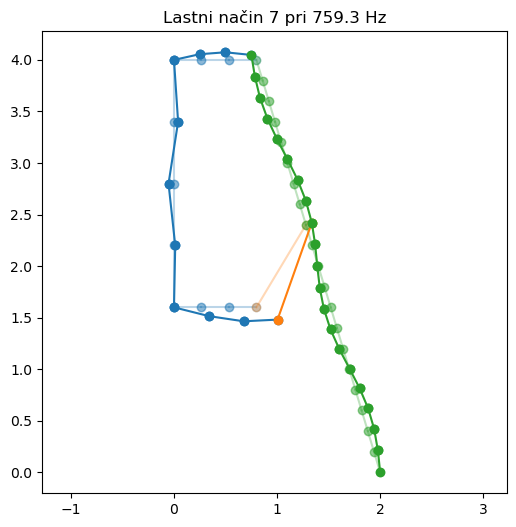

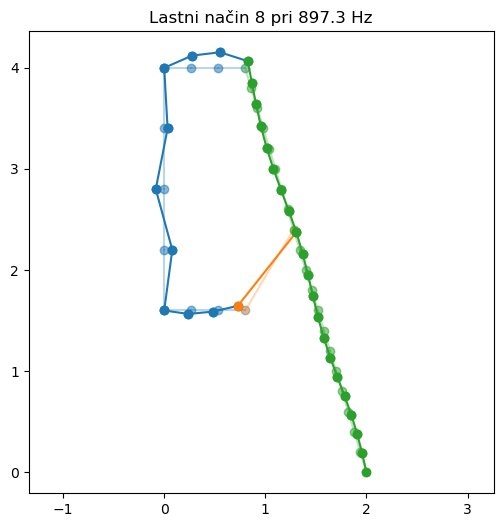

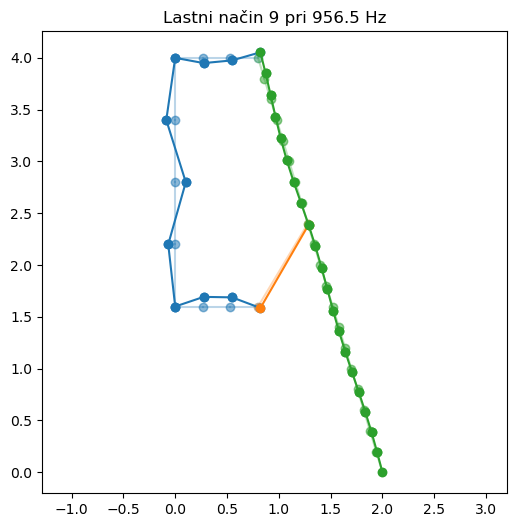

In [67]:
# Izbira lastnega načina
for m in np.arange(10):
    # scale faktor
    s = 1 

    # pomiki strukture A
    pomiki_x_A = eig_vec_A[0::3, m].real
    pomiki_y_A = eig_vec_A[1::3, m].real

    # pomiki strukture C
    pomiki_x_C = eig_vec_C[0::3, m].real
    pomiki_y_C = eig_vec_C[1::3, m].real

    # pomiki strukture B
    pomiki_x_B = eig_vec_B[0::2, m].real
    pomiki_y_B = eig_vec_B[1::2, m].real

    # deformirane koordinate A
    def_vozlisca_A = np.copy(vozlisca_A)
    def_vozlisca_A[:,0] += pomiki_x_A * s
    def_vozlisca_A[:,1] += pomiki_y_A * s

    # deformirane koordinate C
    def_vozlisca_C = np.copy(vozlisca_C)
    def_vozlisca_C[:,0] += pomiki_x_C * s
    def_vozlisca_C[:,1] += pomiki_y_C * s

    # deformirane koordinate B
    def_vozlisca_B = np.copy(vozlisca_B)
    def_vozlisca_B[:,0] += pomiki_x_B * s
    def_vozlisca_B[:,1] += pomiki_y_B * s
    
    fig, ax = plt.subplots(figsize = (6, 6))
    ax.set_title(f'Lastni način {m} pri {eig_freq[m].round(1)} Hz')
    ax.axis('equal')

    # nedeformirano stanje
    [ax.plot(*vozlisca_A[e].T, '-o', c='C0', alpha=0.3) for e in elementi_A];
    [ax.plot(*vozlisca_B[e].T, '-o', c='C1', alpha=0.3) for e in elementi_B];
    [ax.plot(*vozlisca_C[e].T, '-o', c='C2', alpha=0.3) for e in elementi_C];

    # deformirano stanje
    [ax.plot(*def_vozlisca_A[e].T, '-o', c='C0') for e in elementi_A];
    [ax.plot(*def_vozlisca_B[e].T, '-o', c='C1') for e in elementi_B];
    [ax.plot(*def_vozlisca_C[e].T, '-o', c='C2') for e in elementi_C];
    fig.savefig(f'lastni_nacin_{m}.png')

### Izvoz GIFov prvih N lastnih oblik

In [ ]:
# N = 10
# for m in np.arange(N):
#     s = 0.8

#     # podstruktura A
#     pomiki_x_A = eig_vec_A[0::3,m].real
#     pomiki_y_A = eig_vec_A[1::3,m].real

#     # podstruktura B
#     pomiki_x_B = eig_vec_B[0::2,m].real
#     pomiki_y_B = eig_vec_B[1::2,m].real

#     # podstruktura C
#     pomiki_x_C = eig_vec_C[0::3,m].real
#     pomiki_y_C = eig_vec_C[1::3,m].real

#     def_vozlisca_A = np.copy(vozlisca_A)
#     def_vozlisca_A[:,0] += pomiki_x_A *s
#     def_vozlisca_A[:,1] += pomiki_y_A * s

#     def_vozlisca_B = np.copy(vozlisca_B)
#     def_vozlisca_B[:,0] += pomiki_x_B *s
#     def_vozlisca_B[:,1] += pomiki_y_B * s

#     def_vozlisca_C = np.copy(vozlisca_C)
#     def_vozlisca_C[:,0] += pomiki_x_C *s
#     def_vozlisca_C[:,1] += pomiki_y_C * s

#     # Define the undeformed and deformed coordinates
#     # undeformed_coords_A = vozlisca_A
#     # deformed_coords_A = def_vozlisca_A

#     # undeformed_coords_B = vozlisca_B
#     # deformed_coords_B = def_vozlisca_B

#     # undeformed_coords_C = vozlisca_C
#     # deformed_coords_C = def_vozlisca_C

#     undeformed_coords = np.vstack((vozlisca_A, vozlisca_B, vozlisca_C))
#     deformed_coords = np.vstack((def_vozlisca_A, def_vozlisca_B, def_vozlisca_C))

#     # # Calculate the deformation array
#     deformation = np.array(deformed_coords) - np.array(undeformed_coords)
#     # deformation.shape

#     # # Define the number of frames for each deformation direction
#     n_frames = 20

#     # # Define the animation direction sequence
#     directions = [1, -1]

#     # # Create a figure and axis object
#     fig, ax = plt.subplots()

#     # # Create a scatter plot of the undeformed coordinates
#     # scatter = ax.scatter([c[0] for c in undeformed_coords], [c[1] for c in undeformed_coords], alpha=0.3)

#     # Definicija update funkcije
#     def update(frame):
#         # Najprej počisti prejšnji frame
#         ax.clear()
#         ax.set_title(f'{eig_freq[m].round(1)} Hz')
#         # Prikaz nedeformiranega stanja
#         [ax.plot(vozlisca_A[[i,j],0],vozlisca_A[[i,j],1],'-',c='C0', alpha=0.3) for i,j in elementi_A]
#         ax.plot(vozlisca_A[:,0],vozlisca_A[:,1],'o', alpha=0.3);
#         [ax.plot(vozlisca_B[[i,j],0],vozlisca_B[[i,j],1],'-',c='C1', alpha=0.3) for i,j in elementi_B]
#         ax.plot(vozlisca_B[:,0],vozlisca_B[:,1],'o', alpha=0.3);
#         [ax.plot(vozlisca_C[[i,j],0],vozlisca_C[[i,j],1],'-',c='C2', alpha=0.3) for i,j in elementi_C]
#         ax.plot(vozlisca_C[:,0],vozlisca_C[:,1],'o', alpha=0.3);
        
#         ax.text(0.95, -0.11, f'scale = {s}',
#         verticalalignment='bottom', horizontalalignment='right',
#         transform=ax.transAxes)

#         # Nariše nedeformirane oblike
#         scatter = ax.scatter([c[0] for c in undeformed_coords], [c[1] for c in undeformed_coords], color='black', alpha=0.3)
        
        
#         ax.set_xlim([-0.2, 2.2])
#         ax.set_ylim([-0.2, 4.2])
#         direction = directions[frame // (2 * n_frames)]
#         frame = frame % (2 * n_frames)
#         alpha = frame / n_frames if frame < n_frames else (2 * n_frames - frame) / n_frames
#         factor = direction * alpha
        
#         # Calculate the current coordinates based on the current deformation factor
#         coords = [[u[0] + factor * d[0], u[1] + factor * d[1]] for u, d in zip(undeformed_coords, deformation)]
        
#         # Update the scatter plot with the current coordinates
#         scatter.set_offsets((coords));
#         v_A = np.array(coords[:len(vozlisca_A)])
#         v_B = np.array(coords[len(vozlisca_A):len(vozlisca_A)+len(vozlisca_B)])
#         v_C = np.array(coords[-len(vozlisca_C):])
        
#         [ax.plot(v_A[[i,j],0],v_A[[i,j],1],'-o',c='C0', alpha=1) for i,j in elementi_A];
#         [ax.plot(v_B[[i,j],0],v_B[[i,j],1],'-o',c='C1', alpha=1) for i,j in elementi_B];
#         [ax.plot(v_C[[i,j],0],v_C[[i,j],1],'-o',c='C2', alpha=1) for i,j in elementi_C];
        
        
        
#         # Return the scatter plot for this frame
#         return scatter,

#     # Define the total number of frames for the animations
#     total_frames = 4 * n_frames;

#     # Create the animation object
#     animation = FuncAnimation(fig, update, frames=total_frames, interval=50);

#     # Shranimo GIFe
#     animation.save(f'Mode_{m}.gif', writer='imagemagick');
#     print(f'GIF {m} ustvarjen!')


## Harmonska analiza

In [ ]:
# Določitev vzbujanja
#amplituda vzbujevalnih sil
Fx = 58600 #N
Fy = 24700 #N

f_glob = np.zeros(3*len(vozlisca_A) + 2*len(vozlisca_B) + 3*len(vozlisca_C)) # pazimo na robne pogoje
print(f'vozlisca A: {len(vozlisca_A)}: \t{3*len(vozlisca_A)}')
print(f'vozlisca B: {len(vozlisca_B)}: \t\t{2*len(vozlisca_B)}')
print(f'vozlisca C: {len(vozlisca_C)}: \t{3*len(vozlisca_C)}')
print('____________________________')
print(f'f_glob: \t\t{len(f_glob)}')

ind_voz1 = len(vozlisca_A)-2 #tocka vzbujanja
ind_x1, ind_y1, ind_phi1 = 3*ind_voz1+np.array([0,1,2]) #prostostne stopnje vzbujanja
f_glob[ind_x1] = Fx
f_glob[ind_y1] = Fy

# ind_voz2 = 6 #tocka vzbujanja
# ind_x2, ind_y2, ind_phi2 = 3*ind_voz2+np.array([0,1,2]) #prostostne stopnje vzbujanja
# f_glob[ind_x2] = -Fx/2
# f_glob[ind_y2] = Fy/2

merjeno_v = 33 # idneks merjene točke


vozlisca A: 11: 	33
vozlisca B: 2: 		4
vozlisca C: 21: 	63
____________________________
f_glob: 		100


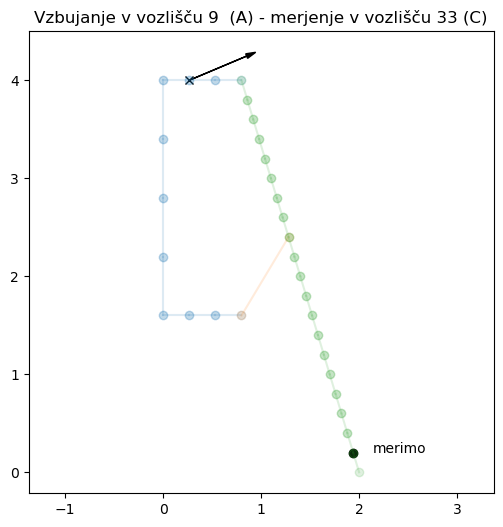

In [ ]:

fig, ax = plt.subplots(figsize = (6, 6))
ax.set_title(f'Vzbujanje v vozlišču {ind_voz1}  (A) - merjenje v vozlišču {merjeno_v} (C)')
ax.axis('equal')

scale_f = 0.00001

ax.plot(vozlisca_A[ind_voz1,0],vozlisca_A[ind_voz1,1],'x',lw=3,  c='black', alpha=1);
ax.arrow(vozlisca_A[ind_voz1,0],vozlisca_A[ind_voz1,1], f_glob[ind_x1]*scale_f, f_glob[ind_y1]*scale_f, head_width=0.05, head_length=0.1, fc='k', ec='k')

# ax.plot(vozlisca_A[ind_voz2,0],vozlisca_A[ind_voz2,1],'x',lw=3,  c='black', alpha=1);
# ax.arrow(vozlisca_A[ind_voz2,0],vozlisca_A[ind_voz2,1], f_glob[ind_x2]*scale_f, f_glob[ind_y2]*scale_f, head_width=0.05, head_length=0.1, fc='k', ec='k')
ax.annotate("merimo", (v[merjeno_v,0] + 0.2,v[merjeno_v,1]), color='black', size=10)
ax.plot(v[merjeno_v,0],v[merjeno_v,1],'o',lw=3,  c='black', alpha=1);
# nedeformirano stanje
[ax.plot(*vozlisca_A[e].T, '-o', c='C0', alpha=0.15) for e in elementi_A];
[ax.plot(*vozlisca_B[e].T, '-o', c='C1', alpha=0.15) for e in elementi_B];
[ax.plot(*vozlisca_C[e].T, '-o', c='C2', alpha=0.15) for e in elementi_C];
fig.savefig(f'vzbujanje_{ind_voz1}_merjenje_{merjeno_v}.png')

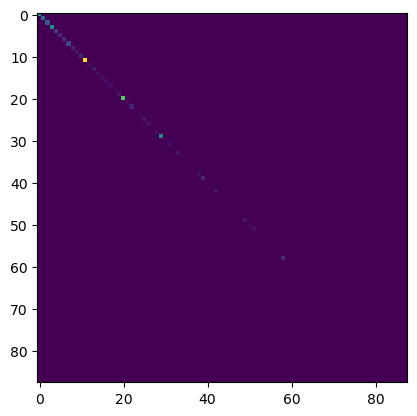

In [ ]:
plt.imshow(eig_vec.T @ M_glob_ABC @ eig_vec);

In [ ]:
m_mod = np.diagonal(eig_vec.T @ M_glob_ABC @ eig_vec) #modalne mase
Φ = eig_vec / m_mod**0.5

(Φ.T @ M_glob_ABC @ Φ).round(1)

array([[ 1., -0., -0., ...,  0., -0., -0.],
       [-0.,  1.,  0., ..., -0.,  0.,  0.],
       [-0.,  0.,  1., ..., -0., -0.,  0.],
       ...,
       [ 0., -0., -0., ...,  1.,  0., -0.],
       [-0.,  0., -0., ...,  0.,  1.,  0.],
       [-0.,  0.,  0., ..., -0.,  0.,  1.]])

In [ ]:
proste_ps_A = np.arange(3*len(vozlisca_A)).flatten()
proste_ps_B = np.arange(2*len(vozlisca_B)).flatten() + 3*len(vozlisca_A)
proste_ps_C = np.arange(3*len(vozlisca_C)).flatten() + 3*len(vozlisca_A) + 2*len(vozlisca_B)
vpete_ps = np.hstack([ind_vpetih_ps_A, ind_vpetih_ps_C + (len(proste_ps_A) + len(proste_ps_B))])

proste_ps = np.hstack([proste_ps_A, proste_ps_B, proste_ps_C])
pkp_ps = np.array([0, 1, 9, 10, proste_ps_C[indeks_C*3+0], proste_ps_C[indeks_C*3+1]])
zares_proste = np.setdiff1d(proste_ps, vpete_ps)
zareszares_proste = np.setdiff1d(zares_proste, pkp_ps)
vpete_ps, pkp_ps, zares_proste, zareszares_proste.shape
M_m = Φ.T @ M_glob_ABC @ Φ
K_m = Φ.T @ K_glob_ABC @ Φ
proste_ps.shape
h_m = Φ.T @ f_glob[zareszares_proste]

In [ ]:
Z=len(eig_val)
δ = 0.003 # malo dušenja, za dobro mero (predpostavimo, da je dušenje enako za vse modale)
ω = np.arange(5000)

H_mod = np.zeros([Z,ω.shape[0]],dtype=complex)
phi_i = np.zeros([Z,ω.shape[0]])

for i in range(Z):
    ω_i = eig_val[i].real**0.5    
    H_mod[i] = h_m[i]/M_m[i,i]/(-ω**2+ω_i**2+2.j*δ*ω*ω_i)
    phi_i[i] = np.arctan2(2*δ*ω/ω_i, 1-(ω/ω_i)**2)
    
H_fiz = Φ @ H_mod

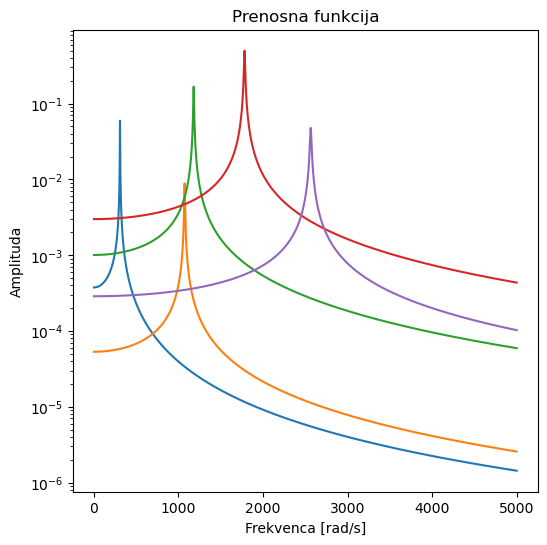

In [ ]:

fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title("Prenosna funkcija")
ax.set_xlabel("Frekvenca [rad/s]")
ax.set_ylabel("Amplituda")
ax.semilogy(np.abs(H_mod[:5]).T);
fig.savefig('prenosna_funkcija.png')

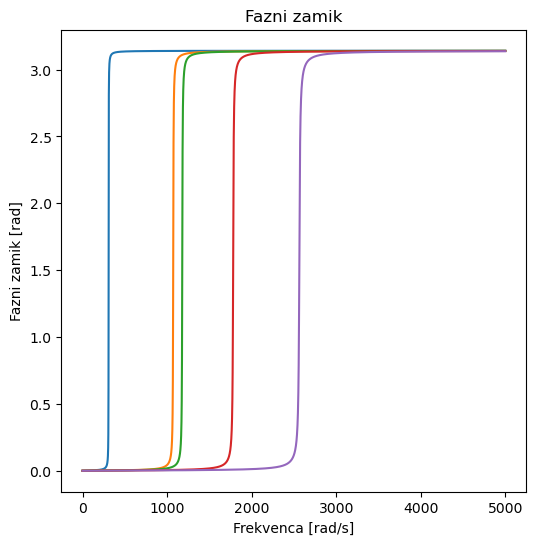

In [ ]:

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Fazni zamik")
ax.set_xlabel("Frekvenca [rad/s]")
ax.set_ylabel("Fazni zamik [rad]")
ax.plot(phi_i[:5].T);
fig.savefig('fazni_zamik.png')

In [ ]:
# ind_x, ind_y, ind_phi = 3*merjeno_v + np.array([0,1,2])
# fig, ax = plt.subplots(figsize = (6, 6))
# ax.set_title(f'Vzbujanje in merjenje')
# ax.axis('equal')

# scale_f = 0.0005

# ax.plot(v[merjeno_v,0],v[merjeno_v,1],'x',lw=3,  c='black', alpha=1);
# # nedeformirano stanje
# [ax.plot(*vozlisca_A[e].T, '-o', c='C0', alpha=0.15) for e in elementi_A];
# [ax.plot(*vozlisca_B[e].T, '-o', c='C1', alpha=0.15) for e in elementi_B];
# [ax.plot(*vozlisca_C[e].T, '-o', c='C2', alpha=0.15) for e in elementi_C];

In [ ]:
ω_vzb = 1800 #rad/s
ind_x, ind_y, ind_phi = 3*merjeno_v + np.array([0,1,2])

ind_x = int(np.where(zareszares_proste == ind_x)[0])
ind_y = int(np.where(zareszares_proste == ind_y)[0])
ind_phi = int(np.where(zareszares_proste == ind_phi)[0])


fig, ax = plt.subplots(figsize=(6,4));
ax.set_title(f'Amplitudni spekter pri vzbujanju z $f(t) = \sin({ω_vzb:.0f} \cdot t)$')
ax.semilogy(1000*np.abs(H_fiz[ind_x]),label='x')
ax.semilogy(1000*np.abs(H_fiz[ind_y]),label='y')
ax.axvline(x=ω_vzb,c='g',linestyle='dashed',linewidth=0.8,label=f'$\omega_v$ = {ω_vzb:.1f} rad/s')
ax.set_xlabel('ω [rad/s]')
ax.set_ylabel('pomik [mm]')
ax.legend(loc=(1.01, 0));
fig.savefig(f'Amplitudni spekter_{merjeno_v}.png',dpi=300,bbox_inches='tight')

TypeError: only size-1 arrays can be converted to Python scalars

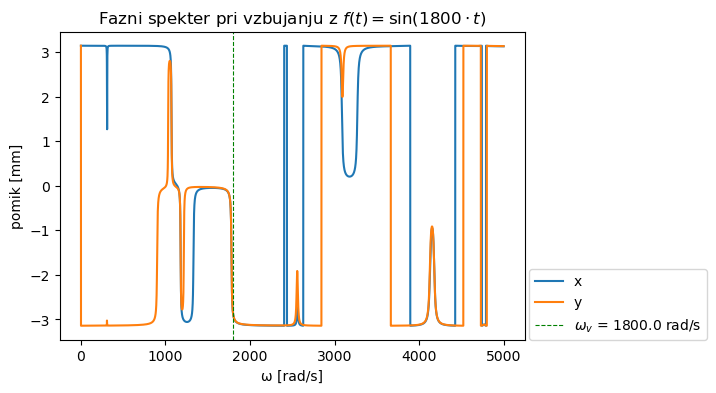

In [ ]:
fig, ax = plt.subplots(figsize=(6,4));
ax.set_title(f'Fazni spekter pri vzbujanju z $f(t) = \sin({ω_vzb:.0f} \cdot t)$')
ax.plot(np.angle(H_fiz[ind_x]),label='x')
ax.plot(np.angle(H_fiz[ind_y]),label='y')
ax.axvline(x=ω_vzb,c='g',linestyle='dashed',linewidth=0.8,label=f'$\omega_v$ = {ω_vzb:.1f} rad/s')
ax.set_xlabel('ω [rad/s]')
ax.set_ylabel('pomik [mm]')
ax.legend(loc=(1.01, 0));
fig.savefig(f'Fazni spekter_{merjeno_v}.png',dpi=300,bbox_inches='tight')

Smer x - amplituda: 	0.008538
Smer x - faza: 		-2.885329
Smer y - amplituda: 	0.028656
Smer y - faza: 		-2.878731


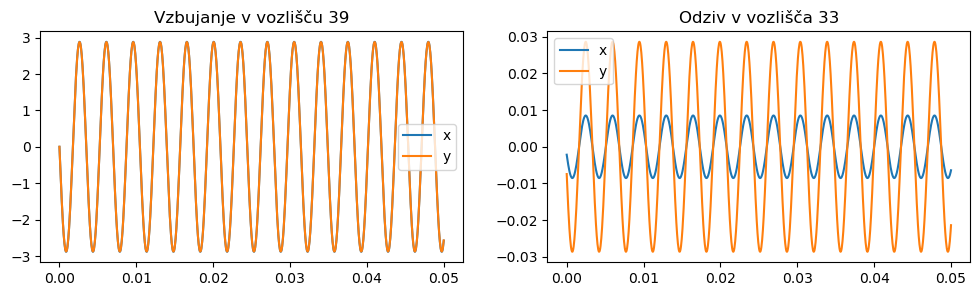

In [ ]:
# Za smer x
A_x = np.abs(H_fiz[ind_x, np.where(ω == ω_vzb)[0]])
F_x = np.angle(H_fiz[ind_x, np.where(ω == ω_vzb)[0]])
# Za smer y
A_y = np.abs(H_fiz[ind_y, np.where(ω == ω_vzb)[0]])
F_y = np.angle(H_fiz[ind_y, np.where(ω == ω_vzb)[0]])

print(f'Smer x - amplituda: \t{A_x[0].round(6)}')
print(f'Smer x - faza: \t\t{F_x[0].round(6)}')
print(f'Smer y - amplituda: \t{A_y[0].round(6)}')
print(f'Smer y - faza: \t\t{F_y[0].round(6)}')

t = np.linspace(0,0.05,1000)

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.title(f'Vzbujanje v vozlišču {ind_voz1}')
plt.plot(t, F_x * np.sin(ω_vzb * t), label='x')
plt.plot(t, F_y * np.sin(ω_vzb * t), label='y')
plt.legend();

plt.subplot(122)
plt.title(f'Odziv v vozlišča {merjeno_v}')
plt.plot(t, A_x * np.sin(ω_vzb * t + F_x), label='x')
plt.plot(t, A_y * np.sin(ω_vzb * t + F_y), label='y')
plt.legend();
plt.savefig('Harmonska_a_3.png',dpi=300)

## Časovna integracija

#### Definirajmo vzbujanje

In [ ]:
len(v)

84

In [ ]:
t0 = 0.2 # trajanje impulza
Amplituda_int = 20000#N

# nova točka za merjenje odziva
merjeno_v = 27

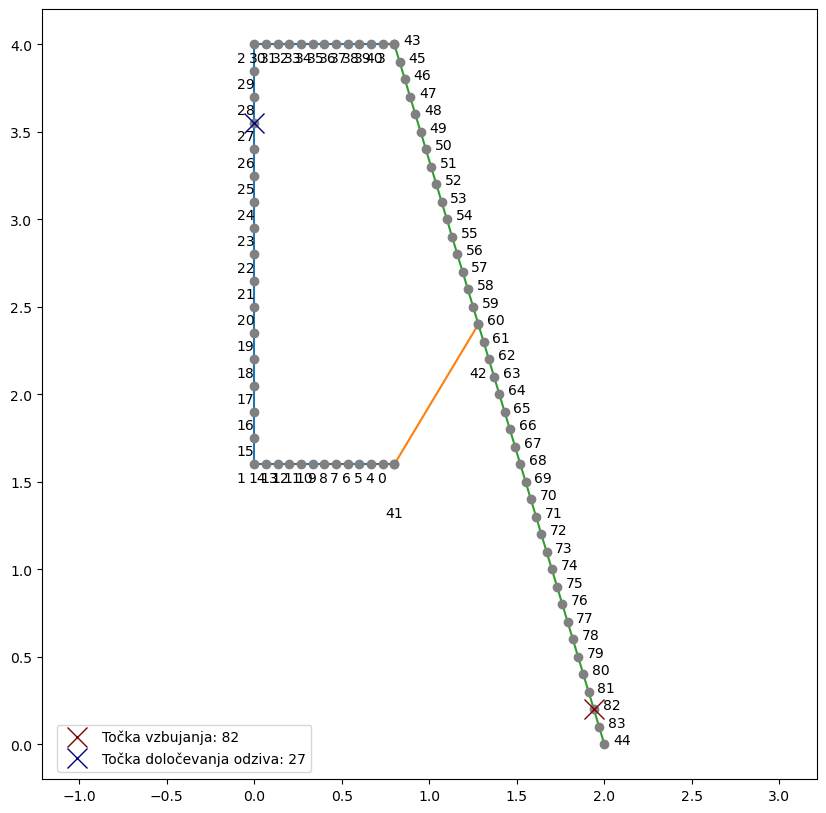

In [ ]:
ind_vozlisca_int = len(v) - 2
ind_vozlisca_int1 = 3 * (ind_vozlisca_int - len(vozlisca_A) - len(vozlisca_B)) + np.array([0,1,2])
ind_x_V, ind_y_V, ind_phi_V = proste_ps_C[ind_vozlisca_int1]


%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
[ax.plot(vozlisca_A[[i,j],0],vozlisca_A[[i,j],1],'-',c='C0') for i,j in elementi_A]
[ax.plot(vozlisca_B[[i,j],0],vozlisca_B[[i,j],1],'-',c='C1') for i,j in elementi_B]
[ax.plot(vozlisca_C[[i,j],0],vozlisca_C[[i,j],1],'-',c='C2') for i,j in elementi_C]
[ax.text(*c,n) for n, c in enumerate(v[:len(vozlisca_A), :]-[0.1, 0.1])];
[ax.text(*c,n+len(vozlisca_A)) for n, c in enumerate(v[len(vozlisca_A):len(vozlisca_A)+len(vozlisca_B), :]-[0.05, 0.3])];
[ax.text(*c,n+len(vozlisca_A)+len(vozlisca_B)) for n, c in enumerate(v[-len(vozlisca_C):, :] + [0.05, 0])];
ax.plot(v[:,0],v[:,1],'o', color='grey');

ax.plot(v[ind_vozlisca_int,0], v[ind_vozlisca_int,1], 'x', c='maroon',markersize = 15,label='Točka vzbujanja: '+str(ind_vozlisca_int));
ax.plot(v[merjeno_v,0], v[merjeno_v,1], 'x', c='navy',markersize = 15,label='Točka določevanja odziva: '+str(merjeno_v));

ax.axis('equal');
# ax.set_ylim((-50,1600))
ax.legend(loc=(0.02,0.01));
fig.savefig('vzbujanje_int.png',dpi=300)

In [ ]:
# Definiramo vektor obremenitev - pol-sinusni impulz
def Impulz(t):
    f_glob = np.zeros(3*len(vozlisca_A) + 2*len(vozlisca_B) + 3*len(vozlisca_C)) 
    
    if t < t0:
        f_B = Amplituda_int*np.sin(np.pi*t/t0)
        
    else:
        f_B = 0
    
    f_glob[ind_x_V] =0
    f_glob[ind_y_V] = f_B
    
    return f_glob[zareszares_proste]

In [ ]:
# Umislimo si še proporcionalno dušenje
α = 0.00005
β = 0.000004
C = α*M_glob_ABC + β*K_glob_ABC

In [ ]:
# prehod na sistem DE 1. reda
D = np.block([[-np.linalg.inv(M_glob_ABC)@C, -np.linalg.inv(M_glob_ABC)@K_glob_ABC], 
          [np.eye(M_glob_ABC.shape[0]), np.zeros_like(M_glob_ABC)]])

#integracijska funkcija
def int_fun(t, u): #t-skalar,  u-vektor
    F = np.block([np.linalg.inv(M_glob_ABC)@Impulz(t), np.zeros_like(Impulz(t))])
    return D @ u + F

# začetni pogoj
u0 = np.zeros(2*M_glob_ABC.shape[0])

In [ ]:
# reševanje s knjižnico scipy
t_min = 0
t_max = 5

res = sp.integrate.solve_ivp(int_fun, t_span=(t_min,t_max), y0=u0, method='Radau', t_eval=t_e)

q_dot, q = np.split(res.y,2) #razdelimo na hitrosti in pomike

q.shape #pomiki

NameError: name 't_e' is not defined

In [ ]:
ind_vozlisca_odz = ind_voz1 #definirana ze pri modalni analizi
ind_x_odz, ind_y_odz, ind_phi_odz = np.copy(3*ind_vozlisca_odz + np.array([0,1,2]))

ind_x_odz, ind_y_odz, ind_phi_odz = np.copy([int(np.where(_ == zareszares_proste)[0]) for _ in [ind_x_odz, ind_y_odz, ind_phi_odz]])

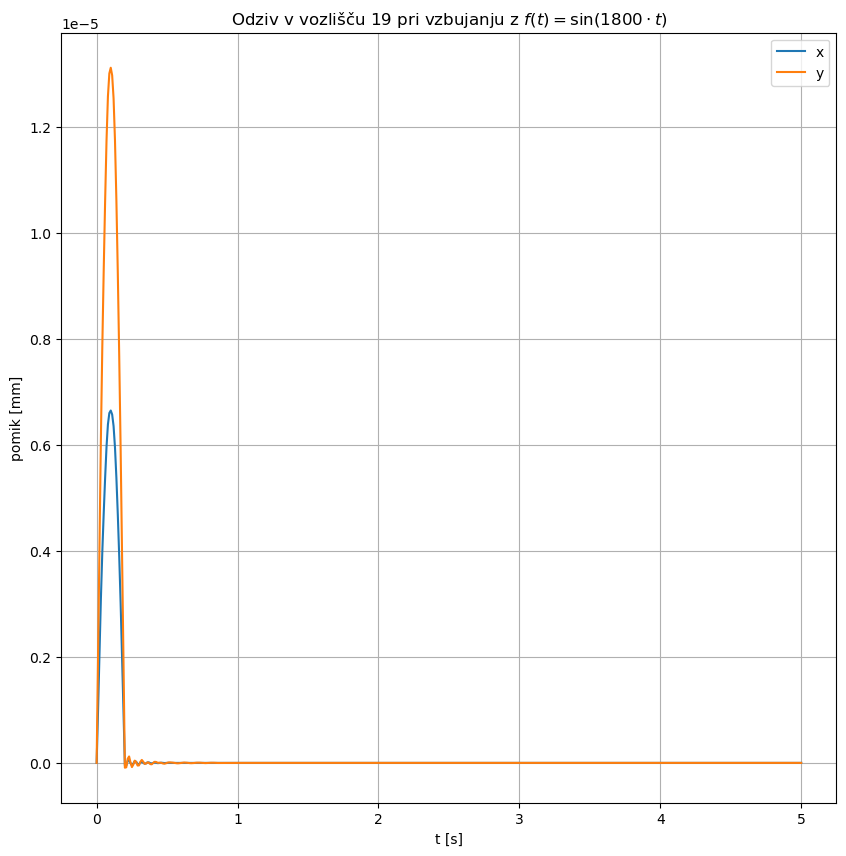

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'Odziv v vozlišču {ind_vozlisca_odz} pri vzbujanju z $f(t) = \sin({ω_vzb:.0f} \cdot t)$')
ax.plot(res.t, q[ind_x_odz], label='x')
ax.plot(res.t, q[ind_y_odz], label='y')
ax.grid()
ax.set_xlabel('t [s]')
ax.set_ylabel('pomik [mm]')
ax.legend();
fig.savefig('odziv_int.png',dpi=300)
